# Ciência de Dados - Trabalho Final

## Alexandre Rosseto Lemos
### PPGI (Mestrado)

## Introdução

O projeto a ser desenvolvido consiste em uma análise histórica da cotação diária do Bitcoin juntamente com outras criptomoedas famosas (Etherium, Cardano, Tether e Binance Coin), índices econômicos de diferentes bolsas mundiais (Ibovespa, S&P 500, Euro Stoxx, Nikkei e Shanghai) e commodities (ouro e preço do barril de petróleo)

Será desenvolvido um modelo que utilizará desses dados para tentar prever a cotação do Bitcoin ao longo de um período (inicialmente idealizado) de 3 anos (01/02/2018 – 31/12/2021).

**Observação:** Como o mercado de criptomoedas funciona 24h todos os dias, o preço de fechamento consiste do último valor do bitcoin no dia, não relacionado ao preço na hora de fechamento de mercado de qualquer país.

**A variável alvo será o preço de fechamento do bitcoin.**

Como a ideia do projeto é calcular o preço de fechamento do bitcoin, todas as variáveis de fechamento dos conjuntos de dados serão removidas antes da criação do modelo, pois considera-se que o tempo de fechamento para todos os dados é o mesmo.

## Engenharia de Variáveis
Nessa sessão serão geradas diferentes features a partir dos dados originais.

Features criadas para cada conjunto separadamente:
- Variação diária do preço (fechamento - abertura)
- Variação máxima do preço (maxima - minima)
- Média, desvio padrão e acumulado nos úlimtos 3, 7 e 15 dias para:
    - Fechamento, abertura, maxima, minima, volume, variação diária do preço e variação máxima do preço
- Média, desvio padrão e acumulado nos últimos 3, 7 e 15 dias para o valor do índice de medo

Após a junção de todos os dados em um único dataframe, as datas dos dias da semana serão extraídas para o conjunto de dados.

## Desenvolvimento do modelo
Essa etapa consiste no desenvolvimento do modelo de regressão utilizado para prefer os preços de fechamento do bitcoin. Essa etapa se divide em:
- Baseline: Diferentes modelos com seus parâmetros default que serão utilizados como baseline para as próximas etapas. Os melhores modelos serão selecionados para as próximas etapas;
- Seleção de características: Serão aplicados algoritmos de seleção de características para diminuir a dimensionalidade do conjunto de dados;
- Otimização de Hipermarâmetros: Serão aplicados algoritmos de otimização de hiperparâmetros do modelo (Optuna) para melhorar a performance dos modelos;
- Resultados e seleção do melhor modelo: Ao final dessa etapa, escolhe-se o modelo que obteve a melhor performance dentro os testados.

## Análise dos resultados
Nessa etapa serão analisados os resultados obtidos pelo melhor modelo.

## Conclusão
Nessa etapa serão feitas as conclusões a respeito do projeto e dos resultados obtidos.

## Dados utilizados
Os dados utilizados serão séries históricas disponibilizados online.

- Os dados de cotação do Bitcoin serão extraídos do https://www.investing.com;
- Os dados de cotação das outras criptomoedas e dados de índices econômicos das diferentes bolsas mundiais serão extraídos do site https://www.investing.com;

OBS: Não foi possível a obtenção dos dados de taxa de desemprego diário, portanto não foi possível utilizá-los para o desenvolvimento deste projeto.
    

# Inicialização

## Carregando bibliotecas

In [1]:
#----------Utilities----------#
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 100

#----------Data Processing----------#
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, mutual_info_regression

#----------Models----------#
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

#----------Model Peformance and Otimization----------#
from sklearn.metrics import mean_squared_error, r2_score
import optuna
import shap

## Funções

### edit_data

In [2]:
def edit_dados(df, data_name):
    '''
    Info:
        Funcao que realiza transformacoes nos dados financeiros
    ----------
    Input:
        df: Dados a serem transformados
        data_name: String com o nome dos dados
    ----------
    Output:
        None
    '''    
    # Alterando a coluna de datas de string para datetime
    df['Date'] = pd.to_datetime(df['Date']).values
    
    try:
        # Alterando colunas de string para float
        for col in ['Price', 'Open', 'High', 'Low']:
            try:
                df[col] = df[col].str.replace(',', '').astype(float)
            except:
                pass

        # Alterando informacao de volume movimentado
        # Obtendo a ordem de magnitude
        try:
            unidade_str = df['Vol.'].str.slice(-1).values
            unidade_num = []
            for i in unidade_str:
                if i == 'K':
                    unidade_num.append(1000)
                elif i == 'M':
                    unidade_num.append(1000000)
                elif i == 'B':
                    unidade_num.append(1000000000)
                else:
                    unidade_num.append(0)

            # Obtendo a quantia movimentada
            # Existem dados com Vol. =  '-' que devem ser removidos
            df['Vol.'] = df['Vol.'].str.replace('-', '0,0').values
            vol_num = df['Vol.'].str.slice(start = 0, stop = -1).str.replace(',', '').astype(float)
            df['Vol.'] = (vol_num*unidade_num).values
            new_cols = ['data', 'fechamento', 'abertura', 'maxima', 'minima', 'volume']
        except:
            # Renomeando as colunas
            new_cols = ['data', 'fechamento', 'abertura', 'maxima', 'minima']

        # Removendo a coluna de variacao (ela contem informacoes da variavel alvo)
        df.drop(columns = ['Change %'], inplace = True)
        
        for col in range(len(new_cols)):
            if new_cols[col] == 'data':
                pass
            else:
                new_cols[col] = data_name + '_' + new_cols[col]

        df.columns = new_cols
        df.set_index('data', inplace = True)
        df.sort_index(inplace = True)
    except:
        new_cols =  df.columns.str.lower()
        df.columns = new_cols
        df.set_index('data', inplace = True)
        df.sort_index(inplace = True)

### obtem_dia_semana

In [3]:
def obtem_dia_semana(df):
    '''
    Info:
        Funcao que obtem o dia da semana a partir da data e utiliza one-hot encoding para gerar
        colunas booleanas para cada dia da semana.
    ----------
    Input:
        df: DataFrame analisado
    ----------
    Output:
        df_out: DataFrame com as novas colunas
    '''
    # Obtendo os dias da semana a partir da data
    df['dia_da_semana'] = (df.reset_index()['data'].dt.dayofweek).values
    
    # Codificando os dias da semana
    df['dia_da_semana'].replace({0: 'domingo', 1: 'segunda', 2: 'terca', 3:'quarta',
                                   4: 'quinta', 5: 'sexta', 6: 'sabado'}, inplace = True)
    
    # Utilizando one-hot-encoding para gerar colunas referentes aos dias da semana
    df_out = pd.get_dummies(df, columns = ['dia_da_semana'])
    
    return df_out

### variacao

In [4]:
def variacao(x1, x2):
    '''
    Info:
        Funcao que calcula a diferenca entre duas variaveis (x1 - x2)
    ----------
    Input:
        x1, x2: Variaveis analisadas
    ----------
    Output:
        Resultado da subtracao
    '''
    return x1 - x2

### calcula_estatisticas_n_dias

In [5]:
def calcula_estatisticas_n_dias(df, var, n_dias):
    '''
    Info:
        Funcao que calcula a media movel, acumulado, e desvio padrao da variavel passada 
        em uma janela (de dias) de tamanho definido pelo usuario.
    ----------
    Input:
        df: DataFrame analisado
        var: Variavel desejada
        n_dias: Tamanho de dias da janela móvel
    ----------
    Output:
        media_movel: Media dos ultimos n dias
        acumulado_n_dias: Acumulado dos ultimos n dias
        std_movel: Desvio padrao dos ultimos n dias
    '''
    # Resetando o indice
    df.reset_index(inplace = True)
    
    # Calculando as estatisticas moveis nos ulitmos n dias para todos os registros
    media_movel = []
    acumulado_n_dias = []
    std_movel = []
    for i in df.index:
        upper_lim = i
        lower_lim = i - n_dias
        try:
            df.loc[lower_lim]
            media = df.loc[lower_lim:upper_lim][var].mean()
            desv = df.loc[lower_lim:upper_lim][var].std(ddof = 0)
            acum = df.loc[lower_lim:upper_lim][var].sum()
        
            # Salvando as medidas em listas
            acumulado_n_dias.append(acum)
            media_movel.append(media)
            std_movel.append(desv)
        except:
            acumulado_n_dias.append(0)
            media_movel.append(0)
            std_movel.append(0)
            
    # Voltando com o indice
    df.set_index('data', inplace = True)

    return media_movel, acumulado_n_dias, std_movel

### run_model

In [6]:
def run_model(df_test, model, X_train, X_test, y_train, y_test):
    '''
    Info:
        Funcao que realiza o preprocessamento dos dados para serem utilizados em um modelo fornecido.
        Os dados são separados em conjuntos de treino e teste, os nulos são tratados, o modelo é treinado
        e utilizado para realizar predição. 
        O RMSE e score R2 são calculados e gera-se um gráfico comparando os valores
        reais dos valores gerados.
    ----------
    Input:
        df_test: Conjunto de dados de teste utilizado
        model: Regressor utilizado
        X_train, y_train: Dados de treino
        X_test, y_test: Dados de teste
    ----------
    Output:
        rmse: RMSE calculado
        y_pred: Valor calculado pelo modelo
    '''
    # Treinando o modelo
    model.fit(X_train, y_train)

    # Calculando a predicao
    y_pred = model.predict(X_test)
    df_test['y_pred'] = y_pred

    # Calculando as metricas do modelo
    rmse = mean_squared_error(y_test, y_pred, squared = False)
    r2 = r2_score(y_test, y_pred)

    # Gerando o gráfico comparando os valores reais com os preditos
    fig, ax = plt.subplots(figsize = [20, 5])
    ax = sns.lineplot(data = df_test, x = df_test.index, y = 'bitcoin_fechamento', marker = 'o', 
                      markersize = 6, linestyle = '--')
    ax = sns.lineplot(data = df_test, x = df_test.index, y = y_pred, marker = '*', 
                      markersize = 6, linestyle = '--')
    plt.legend(['Real', 'Predito'])
    plt.title(f'Bitcoin - Histórico\nR2 = {r2}\nRMSE = {rmse}')
    plt.xlabel('Data')
    plt.ylabel('Valor de fechamento normalizado');
    
    return rmse, r2, y_test, y_pred

### Optuna_gradboost

In [7]:
class Optuna_gradboost:

    def __init__(self, X_train, y_train, X_test, y_test):
        self.best_model = None
        self._model = None
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        
    def __call__(self, trial):
        
        # Parametros
        learning_rate_vl = trial.suggest_loguniform('learning_rate_vl', 0.01, 0.2)
        max_depth_vl = trial.suggest_int('max_depth_vl', 3, 12)
        n_estimators_vl = trial.suggest_int('n_estimators_vl', 8, 128)
        alpha_vl = trial.suggest_loguniform('alpha_vl', 0.5, 0.9)
        
        # Cria modelo
        gradb = GradientBoostingRegressor(learning_rate = learning_rate_vl,
                                          max_depth = max_depth_vl,
                                          n_estimators = n_estimators_vl,
                                          alpha = alpha_vl,
                                          random_state = 0)
        
        # Treinando o modelo
        gradb.fit(self.X_train, self.y_train)
        
        # Predicoes do modelo
        y_pred = gradb.predict(self.X_test)
        
        # Calculando o R2
        score = r2_score(self.y_test, y_pred)
        
        self._model = gradb
        
        return score
    
    def callback(self, study, trial):
        if study.best_trial == trial:
            self.best_model = self._model

### Optuna_rf

In [8]:
class Optuna_rf:

    def __init__(self, X_train, y_train, X_test, y_test):
        self.best_model = None
        self._model = None
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        
    def __call__(self, trial):
        
        # Parametros
        min_samples_split_vl = trial.suggest_int('min_samples_split_vl', 2, 10) 
        max_depth_vl = trial.suggest_int('max_depth_vl', 3, 12)
        n_estimators_vl = trial.suggest_int('n_estimators_vl', 8, 128)
        
        # Cria modelo
        rf = RandomForestRegressor(min_samples_split = min_samples_split_vl,
                                      max_depth = max_depth_vl,
                                      n_estimators = n_estimators_vl,
                                      random_state = 0)
        
        # Treinando o modelo
        rf.fit(self.X_train, self.y_train)
        
        # Predicoes do modelo
        y_pred = rf.predict(self.X_test)
        
        # Calculando o R2
        score = r2_score(self.y_test, y_pred)
        
        self._model = rf
        
        return score
    
    def callback(self, study, trial):
        if study.best_trial == trial:
            self.best_model = self._model

### Optuna_xgb

In [9]:
class Optuna_xgb:

    def __init__(self, X_train, y_train, X_test, y_test):
        self.best_model = None
        self._model = None
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        
    def __call__(self, trial):
        
        # Parametros
        learning_rate_vl = trial.suggest_loguniform('learning_rate_vl', 0.01, 0.2)
        gamma_vl = trial.suggest_loguniform('gamma_vl', 0.01, 0.2)
        max_depth_vl = trial.suggest_int('max_depth_vl', 3, 12)
        reg_lambda_vl = trial.suggest_loguniform('reg_lambda_vl', 0.1, 1.5)
        reg_alpha_vl = trial.suggest_loguniform('reg_alpha_vl', 0.1, 1.5)
        
        # Cria modelo
        xgb = XGBRegressor(learning_rate = learning_rate_vl,
                           gamma = gamma_vl,
                           max_depth = max_depth_vl,
                           reg_lambda = reg_lambda_vl,
                           reg_alpha = reg_alpha_vl,
                           random_state = 0)
        
        # Treinando o modelo
        xgb.fit(self.X_train, self.y_train)
        
        # Predicoes do modelo
        y_pred = xgb.predict(self.X_test)
        
        # Calculando o R2
        score = r2_score(self.y_test, y_pred)
        
        self._model = xgb
        
        return score
    
    def callback(self, study, trial):
        if study.best_trial == trial:
            self.best_model = self._model

## Carregando os dados

### Criptos

In [10]:
# Bitcoin
df_btc = pd.read_csv('./data/bitcoin_data.csv')
edit_dados(df_btc, 'bitcoin')

df_btc.head()

,bitcoin_fechamento,bitcoin_abertura,bitcoin_maxima,bitcoin_minima,bitcoin_volume
data,,,,,
2018-02-01,9181.1,10266.2,10303.0,8789.2,358400.0
2018-02-02,8893.2,9179.8,9201.4,7915.8,519400.0
2018-02-03,9241.1,8894.4,9506.9,8249.3,248710.0
2018-02-04,8222.2,9241.5,9382.1,7932.1,280940.0
2018-02-05,6938.5,8220.8,8383.2,6651.9,593890.0


In [11]:
# Ethereum
df_ether = pd.read_csv('./data/ethereum_data.csv')
edit_dados(df_ether, 'ether')

df_ether.tail()

,ether_fechamento,ether_abertura,ether_maxima,ether_minima,ether_volume
data,,,,,
2021-12-27,4036.24,4062.02,4125.22,4033.04,313320.0
2021-12-28,3791.69,4036.86,4036.86,3760.86,527230.0
2021-12-29,3627.93,3792.95,3825.97,3607.20,456030.0
2021-12-30,3709.57,3629.33,3767.93,3589.64,355720.0
2021-12-31,3677.85,3709.38,3812.01,3623.74,405650.0


In [12]:
# Cardano
df_ada = pd.read_csv('./data/cardano_data.csv')
edit_dados(df_ada, 'cardano')
df_ada.tail()

,cardano_fechamento,cardano_abertura,cardano_maxima,cardano_minima,cardano_volume
data,,,,,
2021-12-27,1.5139,1.4543,1.5912,1.4510,265200000.0
2021-12-28,1.3982,1.5142,1.5381,1.3792,347260000.0
2021-12-29,1.3304,1.3998,1.4368,1.3247,229600000.0
2021-12-30,1.3589,1.3307,1.3778,1.2992,195110000.0
2021-12-31,1.3090,1.3580,1.3819,1.2819,184180000.0


In [13]:
# Binance coin
df_binc = pd.read_csv('./data/binance_coin_data.csv')
edit_dados(df_binc, 'binance')
df_binc.tail()

,binance_fechamento,binance_abertura,binance_maxima,binance_minima,binance_volume
data,,,,,
2021-12-27,563.30,546.49,571.6,543.29,844130.0
2021-12-28,534.19,563.59,563.6,529.27,1050000.0
2021-12-29,514.22,534.21,540.4,511.20,776590.0
2021-12-30,518.50,514.50,527.6,508.81,676810.0
2021-12-31,511.70,518.50,528.1,507.11,726070.0


In [14]:
# Tether
df_teth = pd.read_csv('./data/tether_data.csv')
edit_dados(df_teth, 'tether')
df_teth.tail()

,tether_fechamento,tether_abertura,tether_maxima,tether_minima,tether_volume
data,,,,,
2021-12-27,1.0003,1.0005,1.0007,1.0002,167310000.0
2021-12-28,1.0001,1.0003,1.0005,1.0000,233250000.0
2021-12-29,1.0001,1.0002,1.0003,0.9999,300310000.0
2021-12-30,1.0000,1.0000,1.0003,0.9996,383650000.0
2021-12-31,1.0000,1.0000,1.0001,0.9998,170590000.0


In [15]:
# Fear and Greed index
df_fear = pd.read_csv('./data/fear_and_greed_index.csv')
df_fear['date'] = pd.to_datetime(df_fear['date'], format = '%Y-%m-%d').values
df_fear.rename(columns = {'date': 'data'}, inplace = True)
df_fear.set_index('data',  inplace = True)

# Removendo a coluna fng_classification pois ela possui uma alta correlacao com a coluna fng_value
df_fear.drop(columns = 'fng_classification', inplace = True)
df_fear.head()

,fng_value
data,
2021-12-26,37
2021-12-25,39
2021-12-24,41
2021-12-23,34
2021-12-22,45


### Índices de bolsas mundiais

In [16]:
# Ibovespa
df_ibov = pd.read_csv('./data/ibovespa_data.csv')
edit_dados(df_ibov, 'ibov')
df_ibov.tail()

,ibov_fechamento,ibov_abertura,ibov_maxima,ibov_minima,ibov_volume
data,,,,,
2021-12-23,104891.0,105251.0,105453.0,104637.0,7280000.0
2021-12-27,105554.0,104892.0,105694.0,104798.0,7590000.0
2021-12-28,104864.0,105555.0,105652.0,104503.0,7510000.0
2021-12-29,104107.0,104863.0,105190.0,103851.0,6590000.0
2021-12-30,104822.0,104106.0,105269.0,104106.0,11140000.0


In [17]:
# S&P 500
df_sp = pd.read_csv('./data/s_p_500_data.csv')
edit_dados(df_sp, 'sp_500')
df_sp.tail()

,sp_500_fechamento,sp_500_abertura,sp_500_maxima,sp_500_minima,sp_500_volume
data,,,,,
2021-12-27,4791.19,4733.99,4791.49,4733.99,0.0
2021-12-28,4786.36,4795.49,4807.02,4780.04,0.0
2021-12-29,4793.06,4788.64,4804.06,4778.08,0.0
2021-12-30,4778.73,4794.23,4808.93,4775.33,0.0
2021-12-31,4766.18,4775.21,4786.83,4765.75,0.0


In [18]:
# NASDAQ
df_nasdaq = pd.read_csv('./data/nasdaq_data.csv')
edit_dados(df_nasdaq, 'nasdaq')
df_nasdaq.tail()

,nasdaq_fechamento,nasdaq_abertura,nasdaq_maxima,nasdaq_minima,nasdaq_volume
data,,,,,
2021-12-27,15871.26,15696.83,15871.40,15696.83,741100000.0
2021-12-28,15781.72,15895.20,15901.47,15757.07,691470000.0
2021-12-29,15766.22,15794.92,15821.81,15679.85,699590000.0
2021-12-30,15741.56,15758.98,15868.09,15729.16,768180000.0
2021-12-31,15644.97,15722.91,15777.43,15643.93,729410000.0


In [19]:
# Nikkei
df_nikkei = pd.read_csv('./data/nikkei_data.csv')
edit_dados(df_nikkei, 'nikkei')
df_nikkei.tail()

,nikkei_fechamento,nikkei_abertura,nikkei_maxima,nikkei_minima,nikkei_volume
data,,,,,
2021-12-24,28782.59,28836.05,28870.13,28773.50,359090000.0
2021-12-27,28676.46,28786.33,28805.28,28658.82,374870000.0
2021-12-28,29069.16,28953.32,29121.01,28879.68,470400000.0
2021-12-29,28906.88,28995.73,29106.28,28729.61,447110000.0
2021-12-30,28791.71,28794.24,28904.42,28579.49,403890000.0


In [20]:
# Shanghai
df_shang = pd.read_csv('./data/shanghai_data.csv')
edit_dados(df_shang, 'shanghai')
df_shang.tail()

,shanghai_fechamento,shanghai_abertura,shanghai_maxima,shanghai_minima,shanghai_volume
data,,,,,
2021-12-27,3615.97,3613.05,3632.19,3601.94,3.292000e+10
2021-12-28,3630.11,3619.64,3631.08,3607.36,3.162000e+10
2021-12-29,3597.00,3630.92,3630.92,3596.32,3.051000e+10
2021-12-30,3619.19,3596.49,3628.92,3595.50,3.078000e+10
2021-12-31,3639.78,3626.24,3642.84,3624.94,3.297000e+10


In [21]:
# Euro STX
df_euro_stx = pd.read_csv('./data/euro_stxx_data.csv')
edit_dados(df_euro_stx, 'euro_stx')
df_euro_stx.tail()

,euro_stx_fechamento,euro_stx_abertura,euro_stx_maxima,euro_stx_minima,euro_stx_volume
data,,,,,
2021-12-27,4287.98,4249.90,4293.89,4240.49,13900000.0
2021-12-28,4311.93,4290.54,4319.69,4287.11,16910000.0
2021-12-29,4284.83,4311.13,4312.45,4271.37,16660000.0
2021-12-30,4306.07,4286.63,4309.54,4285.29,18580000.0
2021-12-31,4298.41,4298.41,4298.41,4298.41,0.0


### Commodities

In [22]:
# Ouro
df_ouro = pd.read_csv('./data/ouro_data.csv')
edit_dados(df_ouro, 'ouro')
df_ouro.tail()

,ouro_fechamento,ouro_abertura,ouro_maxima,ouro_minima,ouro_volume
data,,,,,
2021-12-27,1811.1,1809.0,1816.8,1806.0,2570.0
2021-12-28,1813.3,1814.9,1823.6,1808.0,2640.0
2021-12-29,1808.2,1809.8,1810.0,1791.9,3240.0
2021-12-30,1816.6,1807.4,1820.3,1798.8,6520.0
2021-12-31,1831.0,1819.1,1833.6,1818.0,5230.0


In [23]:
# Petróleo
df_petro = pd.read_csv('./data/oil_data.csv')
edit_dados(df_petro, 'petro')
df_petro.tail()

,petro_fechamento,petro_abertura,petro_maxima,petro_minima,petro_volume
data,,,,,
2021-12-27,75.57,73.38,76.09,72.57,268490.0
2021-12-28,75.98,75.97,76.92,75.53,249730.0
2021-12-29,76.56,76.04,77.37,75.36,283560.0
2021-12-30,76.99,76.58,77.44,75.78,231160.0
2021-12-31,75.21,76.66,77.08,74.95,237120.0


# Engenharia de Variáveis

In [24]:
# Lista dos dataframes selecionados
lista_dfs = [df_btc, df_ether, df_ada, df_binc, df_teth, df_ibov, df_sp, 
             df_nasdaq, df_nikkei, df_shang, df_euro_stx, df_ouro, df_petro]

nomes_dfs = ['bitcoin', 'ether', 'cardano', 'binance', 'tether', 'ibov', 'sp_500', 
             'nasdaq', 'nikkei', 'shanghai', 'euro_stx', 'ouro', 'petro']

# Lista de indices das variaveis cujas estatisticas de 3, 7 e 15 dias anteriores serao calculadas
lista_variaveis = [0, 1, 2, 3, 4]
lista_dias = [3, 7, 15]

# Obtendo as variacoes diarias
for i, df in enumerate(lista_dfs):
    
    # Obtendo o nome das colunas
    nomes_variaveis = list(df.columns[lista_variaveis])
    
    # Nomes das colunas de variacao
    nome_var1 = nomes_dfs[i] + '_variacao_dia'
    nome_var2 = nomes_dfs[i] + '_variacao_dia_maxima'
    
    # Obtendo a variacao do dia (fechamento - abertura)
    df[nome_var1] = df.apply(lambda x: variacao(x[df.columns[0]], x[df.columns[1]]), axis = 1)
    
    # Obtendo a variacao maxima do dia (maxima - minima)
    df[nome_var2] = df.apply(lambda x: variacao(x[df.columns[2]], x[df.columns[3]]), axis = 1)
    
    # Adicionando as novas variaveis na lista
    nomes_variaveis.append(nome_var1)
    nomes_variaveis.append(nome_var2)
    
    # Obtendo as estatisticas 
    for var in nomes_variaveis:
        
        # Para os tres periodos especificos:
        for n in lista_dias:
            
            # Nome das novas variaveis
            col_media = var + '_media_' + str(n) + '_dias'
            col_acum = var + '_acum_' + str(n) + '_dias'
            col_std = var + '_std_' + str(n) + '_dias'
            
            # Calculando as metricas
            df[col_media], df[col_acum], df[col_std] = calcula_estatisticas_n_dias(df, var, n)
            
        # Removendo a coluna original, exceto a coluna target do bitcoin
        if var == 'bitcoin_fechamento':
            pass
        else:
            df.drop(columns = var, inplace = True)
            
    # Removendo as primeiras 15 amostras
    df.reset_index(inplace = True)
    df.drop(range(0, 15), axis = 0, inplace = True)
    df.set_index('data', inplace = True)

In [25]:
var = 'fng_value'
# Para os tres periodos especificos:
for n in lista_dias:

    # Nome das novas variaveis
    col_media = var + '_media_' + str(n) + '_dias'
    col_acum = var + '_acum_' + str(n) + '_dias'
    col_std = var + '_std_' + str(n) + '_dias'

    # Calculando as metricas
    df_fear[col_media], df_fear[col_acum], df_fear[col_std] = calcula_estatisticas_n_dias(df_fear, var, n)

# Removendo a coluna original, exceto a coluna target do bitcoin
df_fear.drop(columns = var, inplace = True)

# Removendo as primeiras 15 amostras
df_fear.reset_index(inplace = True)
df_fear.drop(range(0, 15), axis = 0, inplace = True)
df_fear.set_index('data', inplace = True)

#  Juntando  as informações  em um dataframe

In [26]:
# Lista dos dataframes
dataframes = [df_fear, df_ouro, df_petro, df_euro_stx, df_shang,
              df_nikkei,  df_nasdaq, df_sp, df_ibov, df_teth, 
              df_binc, df_ada, df_ether]

# Juntando as informacoes
df = df_btc.join(dataframes)

# Obtendo os dias da semana a partir da data para todos os dataframes
df_btc = obtem_dia_semana(df_btc)

# Previa dos dados
display(df.head())
print('Shape:', df.shape)

,bitcoin_fechamento,bitcoin_fechamento_media_3_dias,bitcoin_fechamento_acum_3_dias,bitcoin_fechamento_std_3_dias,bitcoin_fechamento_media_7_dias,bitcoin_fechamento_acum_7_dias,bitcoin_fechamento_std_7_dias,bitcoin_fechamento_media_15_dias,bitcoin_fechamento_acum_15_dias,bitcoin_fechamento_std_15_dias,bitcoin_abertura_media_3_dias,bitcoin_abertura_acum_3_dias,bitcoin_abertura_std_3_dias,bitcoin_abertura_media_7_dias,bitcoin_abertura_acum_7_dias,bitcoin_abertura_std_7_dias,bitcoin_abertura_media_15_dias,bitcoin_abertura_acum_15_dias,bitcoin_abertura_std_15_dias,bitcoin_maxima_media_3_dias,bitcoin_maxima_acum_3_dias,bitcoin_maxima_std_3_dias,bitcoin_maxima_media_7_dias,bitcoin_maxima_acum_7_dias,bitcoin_maxima_std_7_dias,bitcoin_maxima_media_15_dias,bitcoin_maxima_acum_15_dias,bitcoin_maxima_std_15_dias,bitcoin_minima_media_3_dias,bitcoin_minima_acum_3_dias,bitcoin_minima_std_3_dias,bitcoin_minima_media_7_dias,bitcoin_minima_acum_7_dias,bitcoin_minima_std_7_dias,bitcoin_minima_media_15_dias,bitcoin_minima_acum_15_dias,bitcoin_minima_std_15_dias,bitcoin_volume_media_3_dias,bitcoin_volume_acum_3_dias,bitcoin_volume_std_3_dias,bitcoin_volume_media_7_dias,bitcoin_volume_acum_7_dias,bitcoin_volume_std_7_dias,bitcoin_volume_media_15_dias,bitcoin_volume_acum_15_dias,bitcoin_volume_std_15_dias,bitcoin_variacao_dia_media_3_dias,bitcoin_variacao_dia_acum_3_dias,bitcoin_variacao_dia_std_3_dias,bitcoin_variacao_dia_media_7_dias,...,ether_abertura_acum_7_dias,ether_abertura_std_7_dias,ether_abertura_media_15_dias,ether_abertura_acum_15_dias,ether_abertura_std_15_dias,ether_maxima_media_3_dias,ether_maxima_acum_3_dias,ether_maxima_std_3_dias,ether_maxima_media_7_dias,ether_maxima_acum_7_dias,ether_maxima_std_7_dias,ether_maxima_media_15_dias,ether_maxima_acum_15_dias,ether_maxima_std_15_dias,ether_minima_media_3_dias,ether_minima_acum_3_dias,ether_minima_std_3_dias,ether_minima_media_7_dias,ether_minima_acum_7_dias,ether_minima_std_7_dias,ether_minima_media_15_dias,ether_minima_acum_15_dias,ether_minima_std_15_dias,ether_volume_media_3_dias,ether_volume_acum_3_dias,ether_volume_std_3_dias,ether_volume_media_7_dias,ether_volume_acum_7_dias,ether_volume_std_7_dias,ether_volume_media_15_dias,ether_volume_acum_15_dias,ether_volume_std_15_dias,ether_variacao_dia_media_3_dias,ether_variacao_dia_acum_3_dias,ether_variacao_dia_std_3_dias,ether_variacao_dia_media_7_dias,ether_variacao_dia_acum_7_dias,ether_variacao_dia_std_7_dias,ether_variacao_dia_media_15_dias,ether_variacao_dia_acum_15_dias,ether_variacao_dia_std_15_dias,ether_variacao_dia_maxima_media_3_dias,ether_variacao_dia_maxima_acum_3_dias,ether_variacao_dia_maxima_std_3_dias,ether_variacao_dia_maxima_media_7_dias,ether_variacao_dia_maxima_acum_7_dias,ether_variacao_dia_maxima_std_7_dias,ether_variacao_dia_maxima_media_15_dias,ether_variacao_dia_maxima_acum_15_dias,ether_variacao_dia_maxima_std_15_dias
data,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-02-16,10178.7,9557.875,38231.5,644.132216,9059.5375,72476.3,708.207037,8650.78125,138412.5,844.354581,9238.925,36955.7,565.563354,8807.4875,70459.9,616.050429,8655.67500,138490.8,854.191208,9735.950,38943.8,551.899540,9286.8875,74295.1,611.444917,9124.64375,145994.3,689.925154,8993.950,35975.8,552.077823,8482.4875,67859.9,653.454402,8011.65625,128186.5,887.879101,235117.5,940470.0,37601.024172,239101.25,1912810.0,28175.420777,346421.875,5542750.0,178203.005313,318.950,1275.8,483.942644,252.0500,...,6899.45,42.148758,875.234375,14003.75,102.586574,920.7425,3682.97,31.414838,900.04500,7200.36,33.284203,919.090625,14705.45,87.129410,868.4225,3473.69,37.101487,832.78375,6662.27,45.832672,794.575000,12713.20,95.975200,835595.0,3342380.0,140481.969395,892757.50,7142060.0,127436.109262,1553253.750,24852060.0,9.984548e+05,18.0350,72.14,37.377872,16.49625,131.97,43.820512,-11.108750,-177.74,73.567606,52.3200,209.28,17.101718,67.26125,538.09,21.329506,124.515625,1992.25,71.560101
2018-02-17,1107

Shape: (1415, 829)


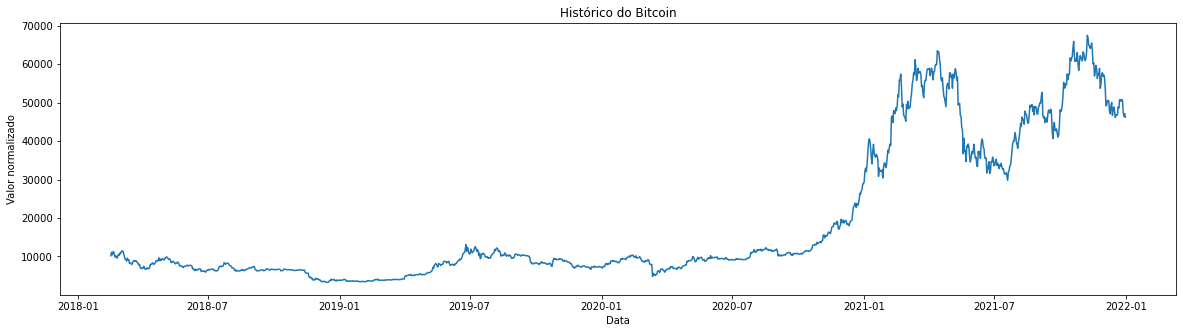

In [27]:
# Evolucao historica do bitcoin
fig, ax = plt.subplots(figsize = [20,5])
ax = sns.lineplot(data = df, x = df.index, y = 'bitcoin_fechamento')
plt.title('Histórico do Bitcoin')
plt.xlabel('Data')
plt.ylabel('Valor normalizado');

Pode-se ver que o bitcoin apresentou um período de certa estabilidade entre 2018 e Ago/2020. Após esse período, é possível perceber períodos de crescimento e queda extremos no preço da criptomoeda.

# Desenvolvimento do modelo

## Baseline
Criando um modelo inicial, sem filtro de caracteríticas e otimização de hiperparâmetros.

Serão testados 5 modelos:
- Random Forest
- Gradient Boost
- XGBoost
- MLP (scikit-learn)
- K-NN

In [28]:
# Separando os dados em treino e teste
df_train = df.loc['2018-02-01':'2021-08-01']
df_test = df.loc['2021-08-01':]

# Separando as caracteristicas da coluna alvo
X_train = df_train.drop(columns = ['bitcoin_fechamento'])
y_train = df_train['bitcoin_fechamento']
X_test = df_test.drop(columns = ['bitcoin_fechamento'])
y_test = df_test['bitcoin_fechamento']

# Obtendo as colunas que possuem valores nulos no conjunto total de dados
df_null = df.isnull().sum().to_frame(name  = 'nulls_cnt')
df_null = df_null[df_null['nulls_cnt'] > 0]

# Substintuindo os nulos pela media (do treino)
for col in df_null.index:
    col_mean = X_train[col].mean()
    X_train[col].fillna(value = col_mean, inplace = True)
    X_test[col].fillna(value = col_mean, inplace = True)


# Normalizando os dados
scaler = StandardScaler()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

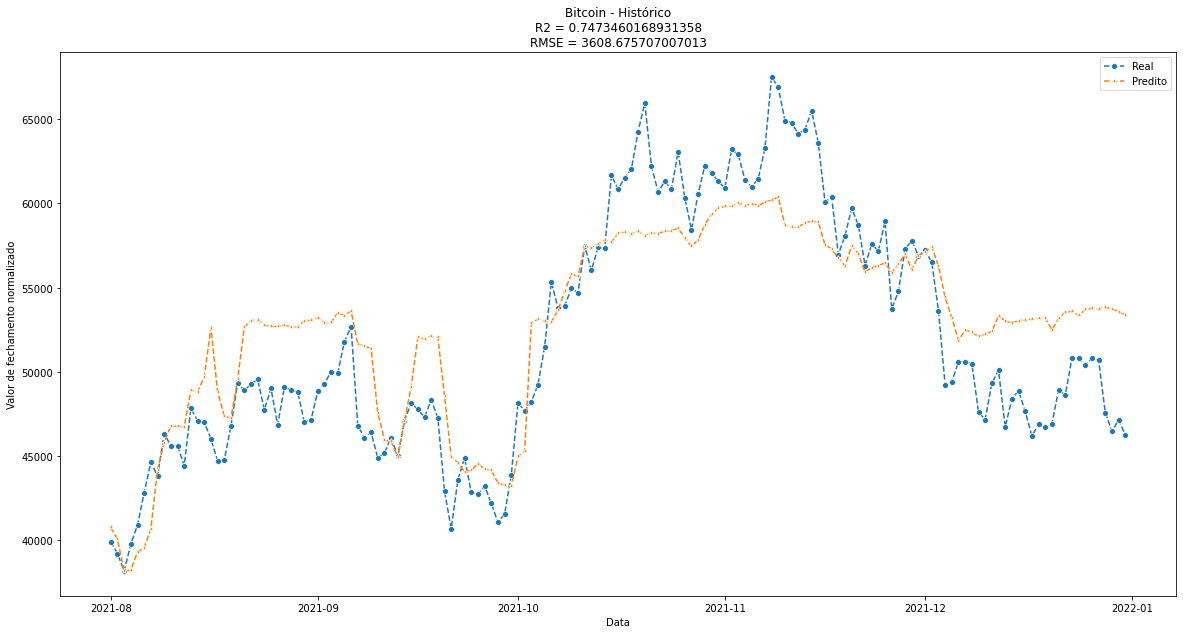

In [29]:
# Inicializando o modelo Random Forest
rf = RandomForestRegressor(random_state = 0)
rmse_rf, r2_rf, y_pred_rf, y_true_rf = run_model(df_test, rf, X_train_norm, X_test_norm, y_train, y_test)

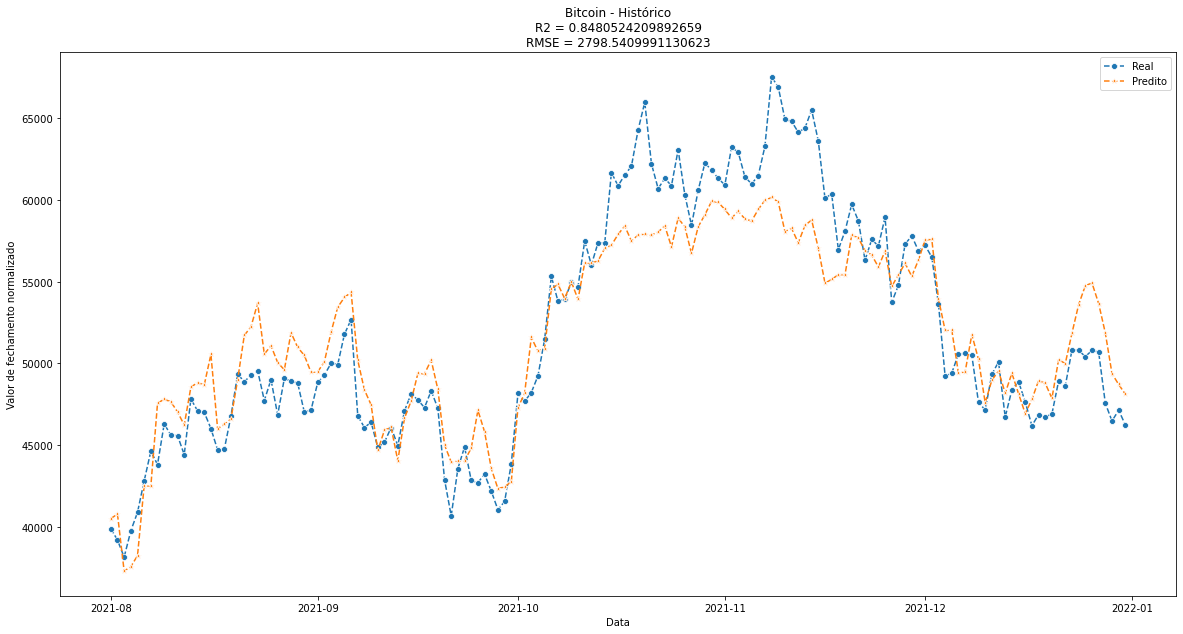

In [30]:
# Inicializando o modelo Gradient Boost
gradboost = GradientBoostingRegressor(random_state = 0)
rmse_gradboost, r2_gradboost, y_pred_gradboost, y_true_gradboost = run_model(df_test, gradboost, X_train_norm, X_test_norm, y_train, y_test)

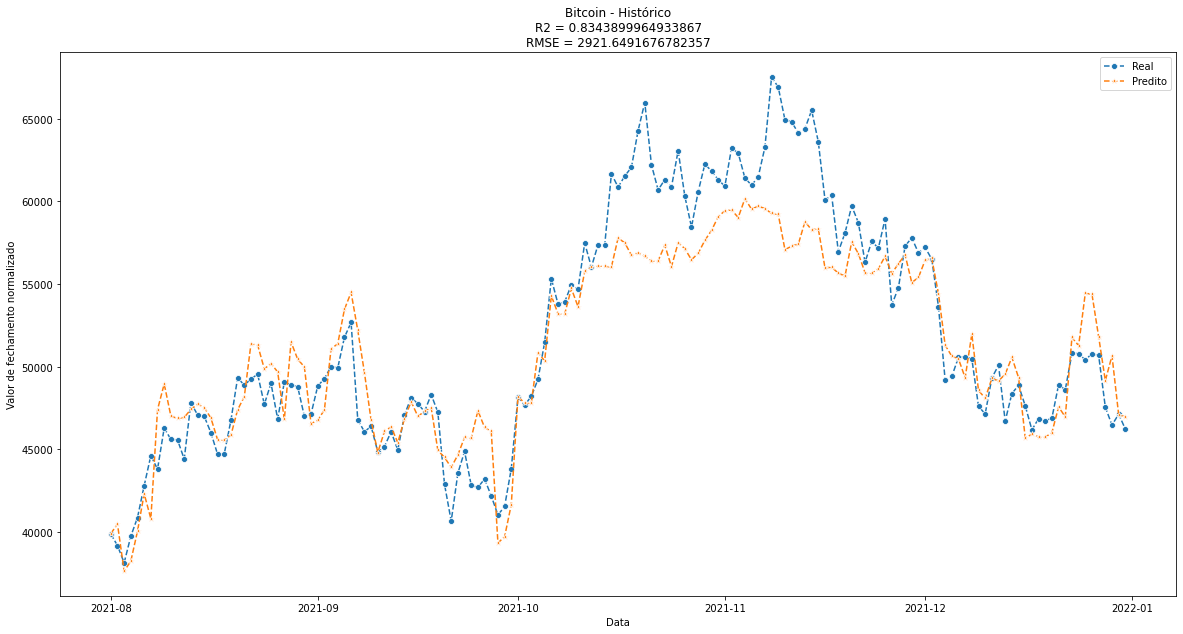

In [31]:
# Inicializando o modelo XGBoost
xgb_reg = XGBRegressor(random_state = 0)
rmse_xgb, r2_xgb, y_pred_xgb, y_true_xgb = run_model(df_test, xgb_reg, X_train_norm, X_test_norm, y_train, y_test)

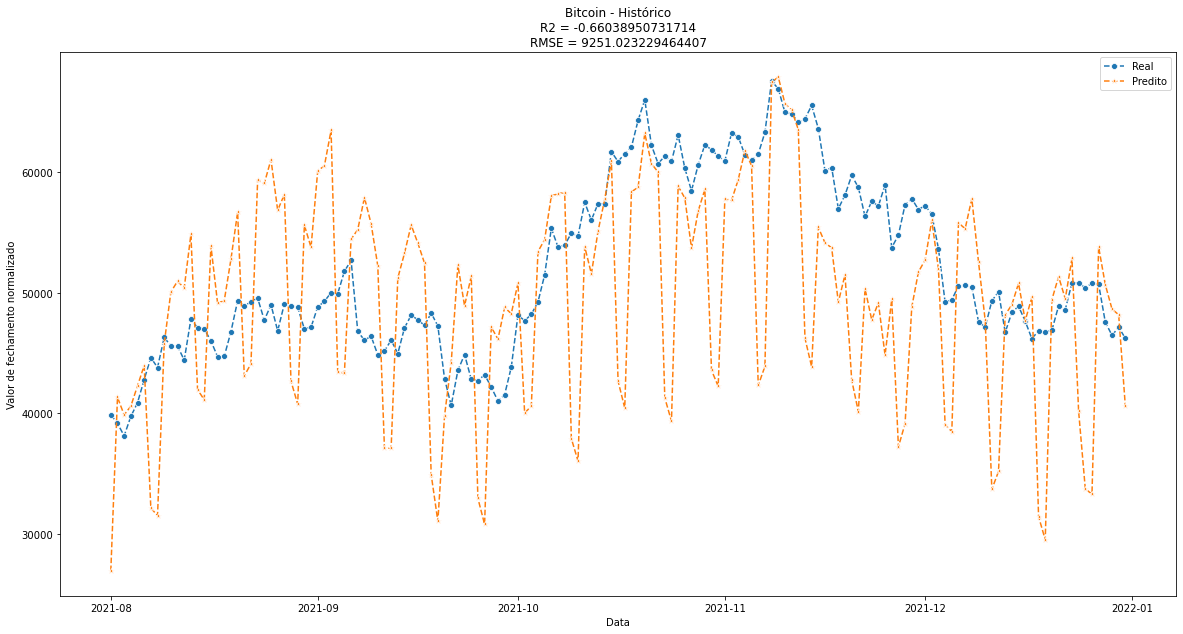

In [32]:
# Inicializando o modelo MLP
mlp_reg = MLPRegressor(random_state = 0)
rmse_mlp, r2_mlp, y_pred_mlp, y_true_mlp = run_model(df_test, mlp_reg, X_train_norm, X_test_norm, y_train, y_test)

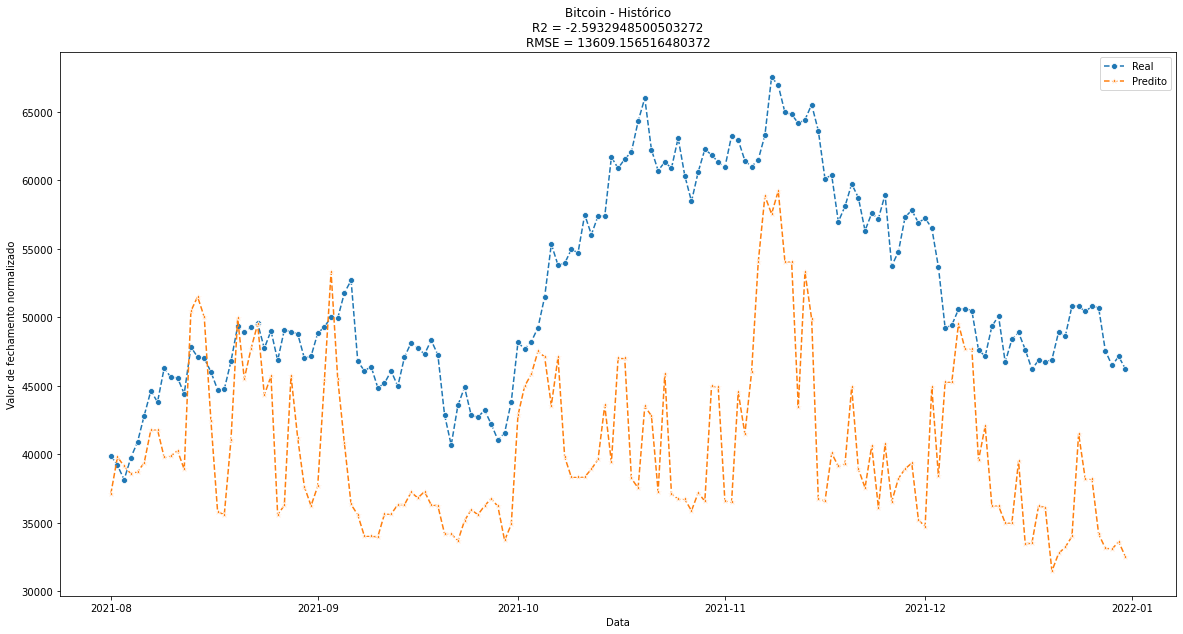

In [33]:
# Inicializando o modelo KNN
knn_reg = KNeighborsRegressor()
rmse_knn, r2_knn, y_pred_knn, y_true_knn = run_model(df_test, knn_reg, X_train_norm, X_test_norm, y_train, y_test)

### Análise
Os modelos baseados em árvore performaram muito melhor quando comparados com o modelo KNN e a rede neural do scikit-learn. Para as etapas seguintes apenas os modelos baseados em árvore serão utilizados.

Observação: Como métodos baseados em árvore são indiferentes à normalização dos dados, nas etapas seguintes os dados não passarão por processo de normalização.

## Seleção de Características
Nessa sessão, serão utilizados diferentes métodos de seleção de características para reduzir a dimensionalidade dos dados utilizados.

A cada etapa será testado se a performance do modelo (Gradient Boost) melhora. Isso será feito apenas para verificação.

In [34]:
# Quantidade original de colunas
qtd_or_col = X_train.shape[1]
print('Quantidade original de colunas:', qtd_or_col)

Quantidade original de colunas: 828


### Removendo características que possuem alta correlação
Nessa sessão, se duas caractertísticas possuírem alta correlação (acima de 0,9) uma delas será removida do conjunto de dados.

In [35]:
# Calculando a matriz de correlacao
corr = X_train.corr()

# Inicializando um vetor (do tamanho da quantidade de colunas original) com valores True
columns = np.full((corr.shape[0],), True, dtype = bool)

# Percorrendo toda a matriz de correlacao
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        
        # Verificando se a correlacao entre duas colunas e superior ao limite
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                
                # Caso seja, muda o valor no vetor
                columns[j] = False
                
# Obtendo as colunas cuja correlacao seja inferior ao limite
selected_columns = list(X_train.columns[columns])

# Quantidade de colunas final
print('Quantidade de colunas final:', len(selected_columns))
print('Quantidade de colunas removidas:', qtd_or_col - len(selected_columns))

# Adicionando a coluna alvo na lista de colunas
selected_columns.append('bitcoin_fechamento')

Quantidade de colunas final: 215
Quantidade de colunas removidas: 613


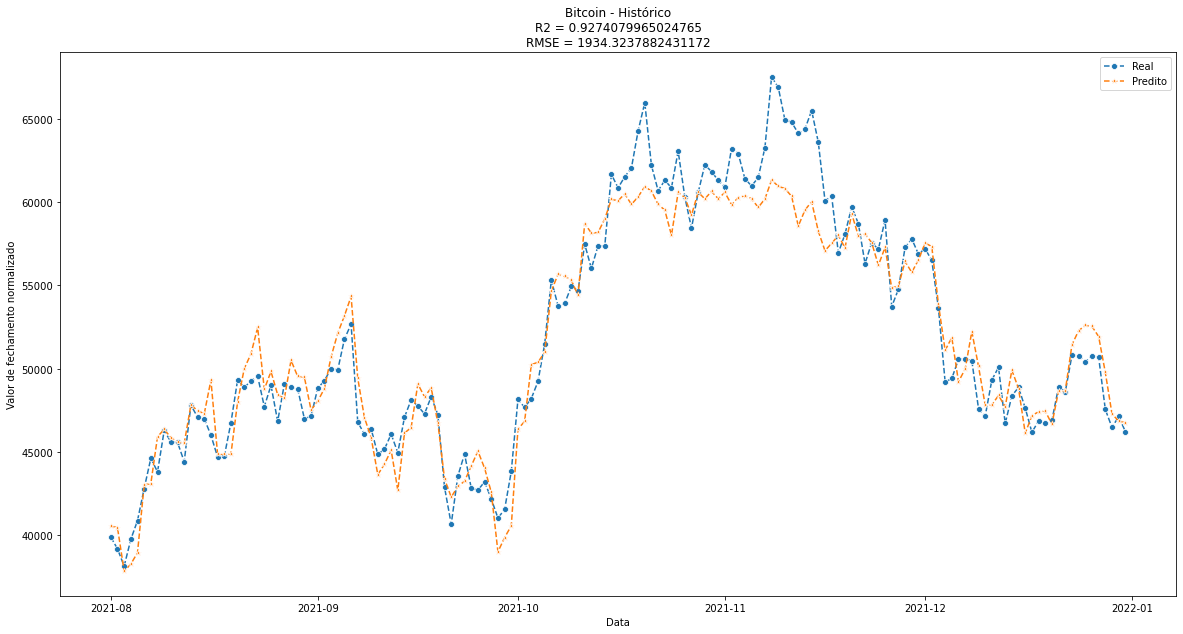

In [36]:
# Usando as colunas selecionadas
df_sel = df[selected_columns]

# Separando os dados em treino e teste
df_train_sel = df_sel.loc['2018-02-01':'2021-08-01']
df_test_sel = df_sel.loc['2021-08-01':]

# Separando as caracteristicas da coluna alvo
X_train_sel = df_train_sel.drop(columns = ['bitcoin_fechamento'])
y_train_sel = df_train_sel['bitcoin_fechamento']
X_test_sel = df_test_sel.drop(columns = ['bitcoin_fechamento'])
y_test_sel = df_test_sel['bitcoin_fechamento']

# Obtendo as colunas que possuem valores nulos no conjunto total de dados
df_null = df_sel.isnull().sum().to_frame(name  = 'nulls_cnt')
df_null = df_null[df_null['nulls_cnt'] > 0]

# Substintuindo os nulos pela media (do treino)
for col in df_null.index:
    col_mean = X_train_sel[col].mean()
    X_train_sel[col].fillna(value = col_mean, inplace = True)
    X_test_sel[col].fillna(value = col_mean, inplace = True)
    
# Inicializando o modelo
gradboost = GradientBoostingRegressor(random_state = 0)
rmse_gradboost, r2_gradboost, y_test_gradboost, y_pred_gradboost = run_model(df_test_sel, gradboost, X_train_sel, X_test_sel, y_train_sel, y_test_sel)

### Selecionando as 100 melhores características baseado em Informação Mútua

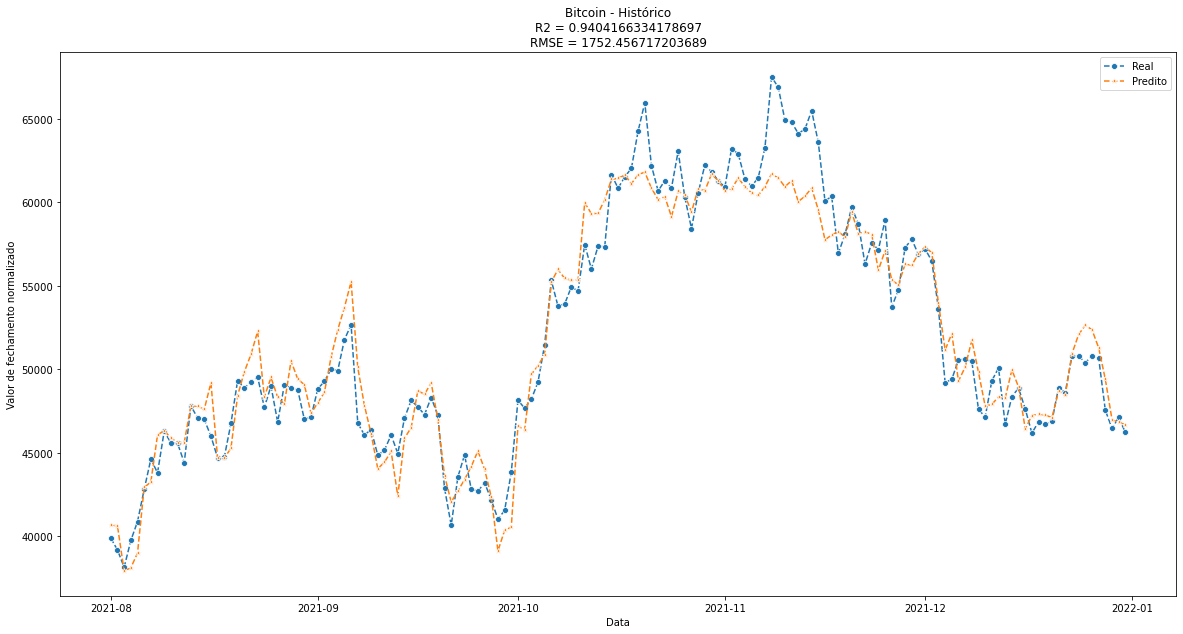

In [37]:
# Inicializando o seletor de caracteristicas
selector = SelectKBest(mutual_info_regression, k = 100)

# Treinando o seletor
selector.fit(X_train_sel, y_train_sel)

# Obtendo as 100 colunas
cols = list(X_train_sel.columns[selector.get_support()])

# Usando as colunas selecionadas
X_train_sel = X_train_sel[cols]
X_test_sel = X_test_sel[cols]

# Inicializando o modelo
gradboost = GradientBoostingRegressor(random_state = 0)
rmse_gradboost, r2_gradboost, y_test_gradboost, y_pred_gradboost = run_model(df_test_sel, gradboost, X_train_sel, X_test_sel, y_train_sel, y_test_sel)

## Otimização de Hiperparâmetros
Nessa sessão será realizada a otimização dos hiperparâmetros dos modelos através do algoritmo Optuna. A métrica utilizada para otimização será o score R2, que representa quão bem o modelo explica a variância da variável dependende.

In [38]:
# Para o modelo Gradient Boost
objective_gradboost = Optuna_gradboost(X_train_sel, y_train_sel, X_test_sel, y_test_sel)

study = optuna.create_study(direction = "maximize", storage = 'sqlite:///optuna_gradboost_saved_trials.db')
study.optimize(objective_gradboost, n_trials = 100, callbacks = [objective_gradboost.callback])

print("Best trial:")
trial = study.best_trial

print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Obtendo o melhor modelo
best_model_gradboost = objective_gradboost.best_model

df_trials = study.trials_dataframe(attrs = ('number', 'value', 'params', 'state'))

[I 2022-03-12 18:55:33,869] A new study created in RDB with name: no-name-53321789-caee-46e5-9312-e1121d4850ff
[I 2022-03-12 18:55:37,283] Trial 0 finished with value: 0.8291199356565364 and parameters: {'learning_rate_vl': 0.14688713003126158, 'max_depth_vl': 4, 'n_estimators_vl': 120, 'alpha_vl': 0.7093038529711077}. Best is trial 0 with value: 0.8291199356565364.
[I 2022-03-12 18:55:38,673] Trial 1 finished with value: -13.41499550466704 and parameters: {'learning_rate_vl': 0.012234003631254271, 'max_depth_vl': 9, 'n_estimators_vl': 26, 'alpha_vl': 0.787199949088575}. Best is trial 0 with value: 0.8291199356565364.
[I 2022-03-12 18:55:41,737] Trial 2 finished with value: 0.5115882872920565 and parameters: {'learning_rate_vl': 0.035262471042905245, 'max_depth_vl': 8, 'n_estimators_vl': 65, 'alpha_vl': 0.50801786938474}. Best is trial 0 with value: 0.8291199356565364.
[I 2022-03-12 18:55:43,130] Trial 3 finished with value: 0.8598340319403601 and parameters: {'learning_rate_vl': 0.069

[I 2022-03-12 18:56:48,168] Trial 30 finished with value: 0.5064523385986055 and parameters: {'learning_rate_vl': 0.1273756999522091, 'max_depth_vl': 10, 'n_estimators_vl': 60, 'alpha_vl': 0.7046517174192517}. Best is trial 23 with value: 0.9387352140081952.
[I 2022-03-12 18:56:49,742] Trial 31 finished with value: 0.9264020688669229 and parameters: {'learning_rate_vl': 0.19454088180411125, 'max_depth_vl': 3, 'n_estimators_vl': 73, 'alpha_vl': 0.7324296696769264}. Best is trial 23 with value: 0.9387352140081952.
[I 2022-03-12 18:56:51,465] Trial 32 finished with value: 0.9332952683708438 and parameters: {'learning_rate_vl': 0.17285346515539227, 'max_depth_vl': 3, 'n_estimators_vl': 80, 'alpha_vl': 0.7309722725418647}. Best is trial 23 with value: 0.9387352140081952.
[I 2022-03-12 18:56:53,422] Trial 33 finished with value: 0.8427307200088369 and parameters: {'learning_rate_vl': 0.19867831763946484, 'max_depth_vl': 4, 'n_estimators_vl': 70, 'alpha_vl': 0.7929966783594775}. Best is trial

[I 2022-03-12 18:57:50,100] Trial 61 finished with value: 0.9337899841587655 and parameters: {'learning_rate_vl': 0.1835855748230029, 'max_depth_vl': 3, 'n_estimators_vl': 73, 'alpha_vl': 0.7260842199323517}. Best is trial 35 with value: 0.9411067744979149.
[I 2022-03-12 18:57:51,878] Trial 62 finished with value: 0.9388562107862991 and parameters: {'learning_rate_vl': 0.15351935752451545, 'max_depth_vl': 3, 'n_estimators_vl': 82, 'alpha_vl': 0.6793806806148591}. Best is trial 35 with value: 0.9411067744979149.
[I 2022-03-12 18:57:53,653] Trial 63 finished with value: 0.9253694755585975 and parameters: {'learning_rate_vl': 0.14783152886116074, 'max_depth_vl': 3, 'n_estimators_vl': 82, 'alpha_vl': 0.6733034147757757}. Best is trial 35 with value: 0.9411067744979149.
[I 2022-03-12 18:57:55,756] Trial 64 finished with value: 0.8272790314935854 and parameters: {'learning_rate_vl': 0.12182340884331751, 'max_depth_vl': 4, 'n_estimators_vl': 76, 'alpha_vl': 0.6423756536636542}. Best is trial 

[I 2022-03-12 18:58:46,311] Trial 92 finished with value: 0.9323195218545751 and parameters: {'learning_rate_vl': 0.1857691667884191, 'max_depth_vl': 3, 'n_estimators_vl': 64, 'alpha_vl': 0.6198313999604003}. Best is trial 65 with value: 0.9428132975846646.
[I 2022-03-12 18:58:47,988] Trial 93 finished with value: 0.8299386107806759 and parameters: {'learning_rate_vl': 0.15306074049518456, 'max_depth_vl': 4, 'n_estimators_vl': 60, 'alpha_vl': 0.7685713420080252}. Best is trial 65 with value: 0.9428132975846646.
[I 2022-03-12 18:58:50,679] Trial 94 finished with value: 0.9387168098928654 and parameters: {'learning_rate_vl': 0.16997682223535282, 'max_depth_vl': 3, 'n_estimators_vl': 127, 'alpha_vl': 0.6988598640048813}. Best is trial 65 with value: 0.9428132975846646.
[I 2022-03-12 18:58:53,156] Trial 95 finished with value: 0.9408506446781452 and parameters: {'learning_rate_vl': 0.16847580014074445, 'max_depth_vl': 3, 'n_estimators_vl': 117, 'alpha_vl': 0.7348587513843332}. Best is tria

Best trial:
Params: 
    alpha_vl: 0.6111688225598036
    learning_rate_vl: 0.1555002401250286
    max_depth_vl: 3
    n_estimators_vl: 79


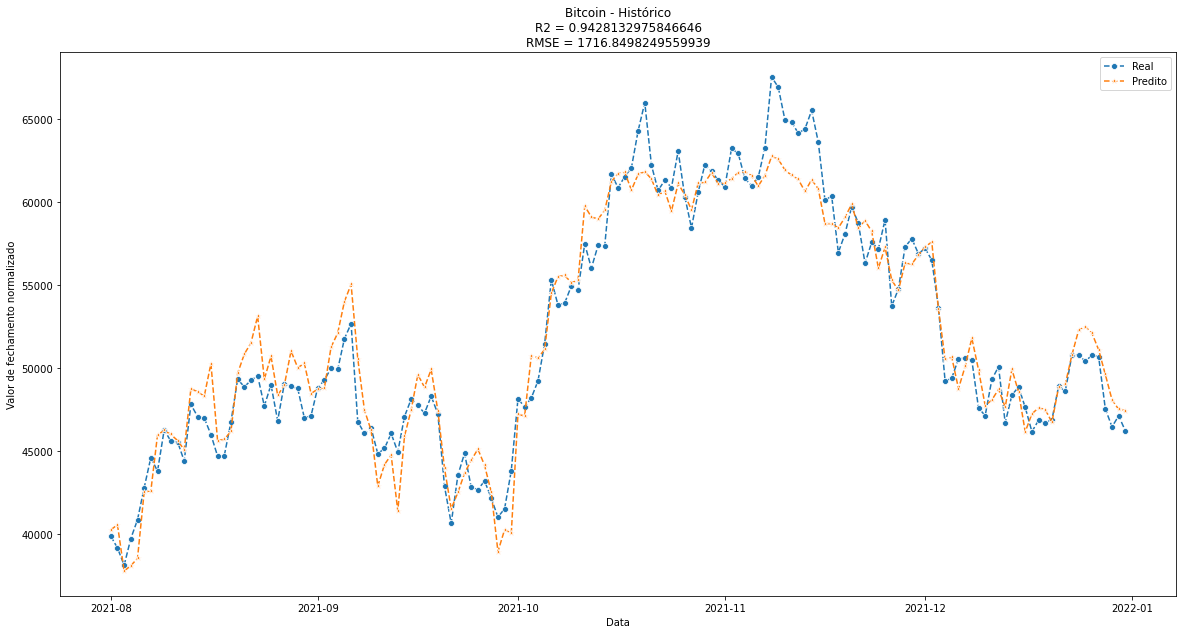

In [39]:
rmse_gradboost_opt, r2_gradboost_opt, y_test_gradboost_opt, y_pred_gradboost_opt = run_model(df_test_sel, best_model_gradboost, X_train_sel, X_test_sel, y_train_sel, y_test_sel)

In [40]:
# Para o modelo Random Forest
objective_rf = Optuna_rf(X_train_sel, y_train_sel, X_test_sel, y_test_sel)

study = optuna.create_study(direction = "maximize", storage ='sqlite:///optuna_rf_saved_trials.db')
study.optimize(objective_rf, n_trials = 100, callbacks = [objective_rf.callback])

print("Best trial:")
trial = study.best_trial

print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Obtendo o melhor modelo
best_model_rf = objective_rf.best_model

df_trials = study.trials_dataframe(attrs = ('number', 'value', 'params', 'state'))

[I 2022-03-12 18:59:08,594] A new study created in RDB with name: no-name-c7371150-49b2-4d78-b3d3-d97433dd324c
[I 2022-03-12 18:59:09,946] Trial 0 finished with value: 0.7777476406013806 and parameters: {'min_samples_split_vl': 8, 'max_depth_vl': 5, 'n_estimators_vl': 65}. Best is trial 0 with value: 0.7777476406013806.
[I 2022-03-12 18:59:12,288] Trial 1 finished with value: 0.7873939753714814 and parameters: {'min_samples_split_vl': 7, 'max_depth_vl': 10, 'n_estimators_vl': 75}. Best is trial 1 with value: 0.7873939753714814.
[I 2022-03-12 18:59:14,352] Trial 2 finished with value: 0.7819708343615236 and parameters: {'min_samples_split_vl': 4, 'max_depth_vl': 12, 'n_estimators_vl': 60}. Best is trial 1 with value: 0.7873939753714814.
[I 2022-03-12 18:59:15,602] Trial 3 finished with value: 0.7945262356778848 and parameters: {'min_samples_split_vl': 7, 'max_depth_vl': 3, 'n_estimators_vl': 92}. Best is trial 3 with value: 0.7945262356778848.
[I 2022-03-12 18:59:18,246] Trial 4 finishe

[I 2022-03-12 18:59:48,686] Trial 36 finished with value: 0.7730052306206205 and parameters: {'min_samples_split_vl': 4, 'max_depth_vl': 12, 'n_estimators_vl': 32}. Best is trial 33 with value: 0.8035211109183801.
[I 2022-03-12 18:59:49,860] Trial 37 finished with value: 0.7918938197092573 and parameters: {'min_samples_split_vl': 5, 'max_depth_vl': 5, 'n_estimators_vl': 55}. Best is trial 33 with value: 0.8035211109183801.
[I 2022-03-12 18:59:50,413] Trial 38 finished with value: 0.802035131550405 and parameters: {'min_samples_split_vl': 4, 'max_depth_vl': 3, 'n_estimators_vl': 37}. Best is trial 33 with value: 0.8035211109183801.
[I 2022-03-12 18:59:51,076] Trial 39 finished with value: 0.7707729424803879 and parameters: {'min_samples_split_vl': 4, 'max_depth_vl': 4, 'n_estimators_vl': 36}. Best is trial 33 with value: 0.8035211109183801.
[I 2022-03-12 18:59:52,105] Trial 40 finished with value: 0.7694235489262838 and parameters: {'min_samples_split_vl': 3, 'max_depth_vl': 11, 'n_esti

[I 2022-03-12 19:00:15,246] Trial 73 finished with value: 0.8056128291975173 and parameters: {'min_samples_split_vl': 5, 'max_depth_vl': 3, 'n_estimators_vl': 34}. Best is trial 71 with value: 0.8056128291975173.
[I 2022-03-12 19:00:15,858] Trial 74 finished with value: 0.7738895280194216 and parameters: {'min_samples_split_vl': 6, 'max_depth_vl': 4, 'n_estimators_vl': 32}. Best is trial 71 with value: 0.8056128291975173.
[I 2022-03-12 19:00:16,204] Trial 75 finished with value: 0.7985659259476889 and parameters: {'min_samples_split_vl': 6, 'max_depth_vl': 3, 'n_estimators_vl': 21}. Best is trial 71 with value: 0.8056128291975173.
[I 2022-03-12 19:00:16,723] Trial 76 finished with value: 0.8056128291975173 and parameters: {'min_samples_split_vl': 5, 'max_depth_vl': 3, 'n_estimators_vl': 34}. Best is trial 71 with value: 0.8056128291975173.
[I 2022-03-12 19:00:17,705] Trial 77 finished with value: 0.7693598788884219 and parameters: {'min_samples_split_vl': 5, 'max_depth_vl': 11, 'n_esti

Best trial:
Params: 
    max_depth_vl: 3
    min_samples_split_vl: 5
    n_estimators_vl: 34


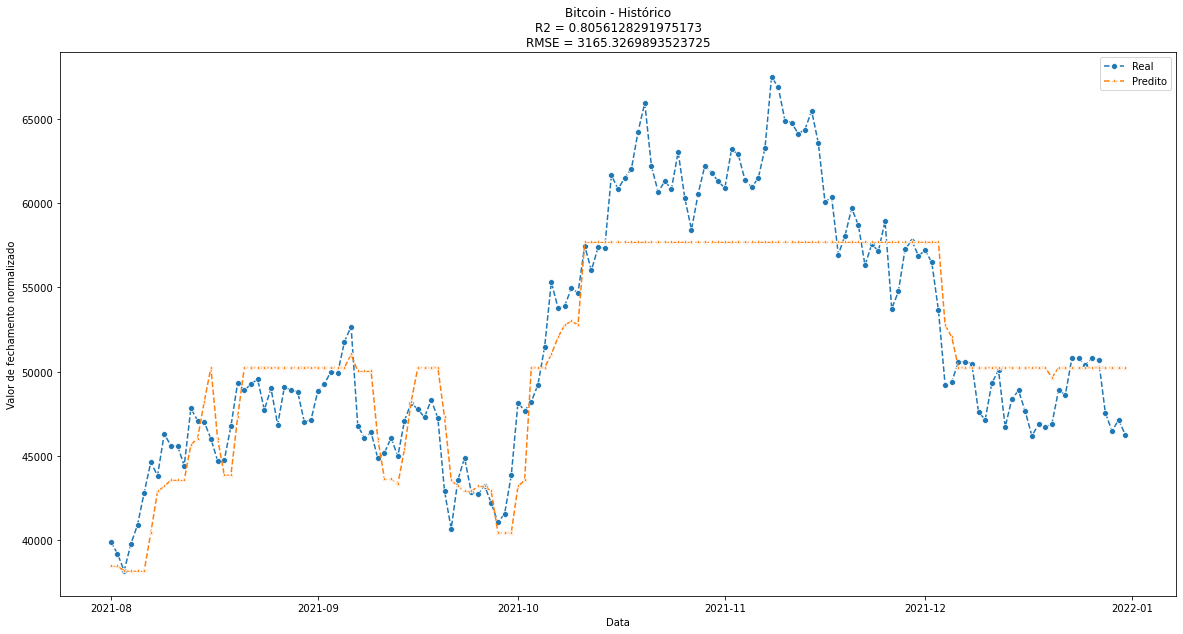

In [41]:
rmse_rf_opt, r2_rf_opt, y_test_rf_opt, y_pred_rf_opt = run_model(df_test_sel, best_model_rf, X_train_sel, X_test_sel, y_train_sel, y_test_sel)

In [42]:
# Para o modelo XGBoost
objective_xgb = Optuna_xgb(X_train_sel, y_train_sel, X_test_sel, y_test_sel)

study = optuna.create_study(direction = "maximize", storage = 'sqlite:///optuna_xgb_saved_trials.db')
study.optimize(objective_xgb, n_trials = 100, callbacks = [objective_xgb.callback])

print("Best trial:")
trial = study.best_trial

print("Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# Obtendo o melhor modelo
best_model_xgb = objective_xgb.best_model

df_trials = study.trials_dataframe(attrs = ('number', 'value', 'params', 'state'))

[I 2022-03-12 19:00:31,409] A new study created in RDB with name: no-name-1c247759-e522-4fb6-9f86-9042809c224b
[I 2022-03-12 19:00:31,771] Trial 0 finished with value: 0.932553667999253 and parameters: {'learning_rate_vl': 0.14329967045738606, 'gamma_vl': 0.07584190720878634, 'max_depth_vl': 3, 'reg_lambda_vl': 0.2712593519512247, 'reg_alpha_vl': 0.5080359681703762}. Best is trial 0 with value: 0.932553667999253.
[I 2022-03-12 19:00:32,341] Trial 1 finished with value: 0.880688669223934 and parameters: {'learning_rate_vl': 0.10465797444493771, 'gamma_vl': 0.04501239040473765, 'max_depth_vl': 12, 'reg_lambda_vl': 0.11345279733580403, 'reg_alpha_vl': 0.31234239242792183}. Best is trial 0 with value: 0.932553667999253.
[I 2022-03-12 19:00:32,568] Trial 2 finished with value: 0.9399958357447044 and parameters: {'learning_rate_vl': 0.10998509566134348, 'gamma_vl': 0.013494063335581296, 'max_depth_vl': 3, 'reg_lambda_vl': 0.13237968418275547, 'reg_alpha_vl': 0.18728571813812064}. Best is tri

[I 2022-03-12 19:00:41,772] Trial 26 finished with value: 0.9133594847976785 and parameters: {'learning_rate_vl': 0.13287794823537916, 'gamma_vl': 0.03347967131809152, 'max_depth_vl': 5, 'reg_lambda_vl': 0.8415045634293083, 'reg_alpha_vl': 0.6105950010874477}. Best is trial 7 with value: 0.9464070668952764.
[I 2022-03-12 19:00:42,165] Trial 27 finished with value: 0.8097869610242141 and parameters: {'learning_rate_vl': 0.032415388250680716, 'gamma_vl': 0.010527239977370392, 'max_depth_vl': 12, 'reg_lambda_vl': 0.3008811102183952, 'reg_alpha_vl': 0.6262095506135317}. Best is trial 7 with value: 0.9464070668952764.
[I 2022-03-12 19:00:42,422] Trial 28 finished with value: 0.927935822837266 and parameters: {'learning_rate_vl': 0.050016752019870436, 'gamma_vl': 0.0158543850564254, 'max_depth_vl': 4, 'reg_lambda_vl': 1.058837741286747, 'reg_alpha_vl': 0.33521257755772826}. Best is trial 7 with value: 0.9464070668952764.
[I 2022-03-12 19:00:42,754] Trial 29 finished with value: 0.93583773089

[I 2022-03-12 19:00:52,583] Trial 52 finished with value: 0.9483649432784098 and parameters: {'learning_rate_vl': 0.08321302082234097, 'gamma_vl': 0.014793953228655517, 'max_depth_vl': 10, 'reg_lambda_vl': 1.3122151646685398, 'reg_alpha_vl': 0.2434088326940675}. Best is trial 43 with value: 0.9491303338976187.
[I 2022-03-12 19:00:53,001] Trial 53 finished with value: 0.9456585100888258 and parameters: {'learning_rate_vl': 0.08567189473452294, 'gamma_vl': 0.014686113824490801, 'max_depth_vl': 10, 'reg_lambda_vl': 1.1451760624546046, 'reg_alpha_vl': 0.23619670231488907}. Best is trial 43 with value: 0.9491303338976187.
[I 2022-03-12 19:00:53,430] Trial 54 finished with value: 0.9448755050576065 and parameters: {'learning_rate_vl': 0.08276816193939382, 'gamma_vl': 0.0143101995240857, 'max_depth_vl': 10, 'reg_lambda_vl': 1.138911638976187, 'reg_alpha_vl': 0.2334794308879211}. Best is trial 43 with value: 0.9491303338976187.
[I 2022-03-12 19:00:53,818] Trial 55 finished with value: 0.924943

[I 2022-03-12 19:01:03,876] Trial 78 finished with value: 0.9452698382124591 and parameters: {'learning_rate_vl': 0.08928094828874986, 'gamma_vl': 0.0579854307478742, 'max_depth_vl': 11, 'reg_lambda_vl': 1.1950662223976882, 'reg_alpha_vl': 0.285403509923331}. Best is trial 67 with value: 0.9496775473173524.
[I 2022-03-12 19:01:04,261] Trial 79 finished with value: 0.7818651966299952 and parameters: {'learning_rate_vl': 0.03209673478601143, 'gamma_vl': 0.011871354449369095, 'max_depth_vl': 9, 'reg_lambda_vl': 0.22985653167160652, 'reg_alpha_vl': 0.15562946308996098}. Best is trial 67 with value: 0.9496775473173524.
[I 2022-03-12 19:01:04,731] Trial 80 finished with value: 0.9276053007158412 and parameters: {'learning_rate_vl': 0.11079894383102713, 'gamma_vl': 0.010149069474229184, 'max_depth_vl': 10, 'reg_lambda_vl': 1.0758820056403382, 'reg_alpha_vl': 0.31857629464466175}. Best is trial 67 with value: 0.9496775473173524.
[I 2022-03-12 19:01:05,205] Trial 81 finished with value: 0.91446

Best trial:
Params: 
    gamma_vl: 0.012777664223961926
    learning_rate_vl: 0.07459059628286929
    max_depth_vl: 11
    reg_alpha_vl: 1.499800279417384
    reg_lambda_vl: 1.3279597839591857


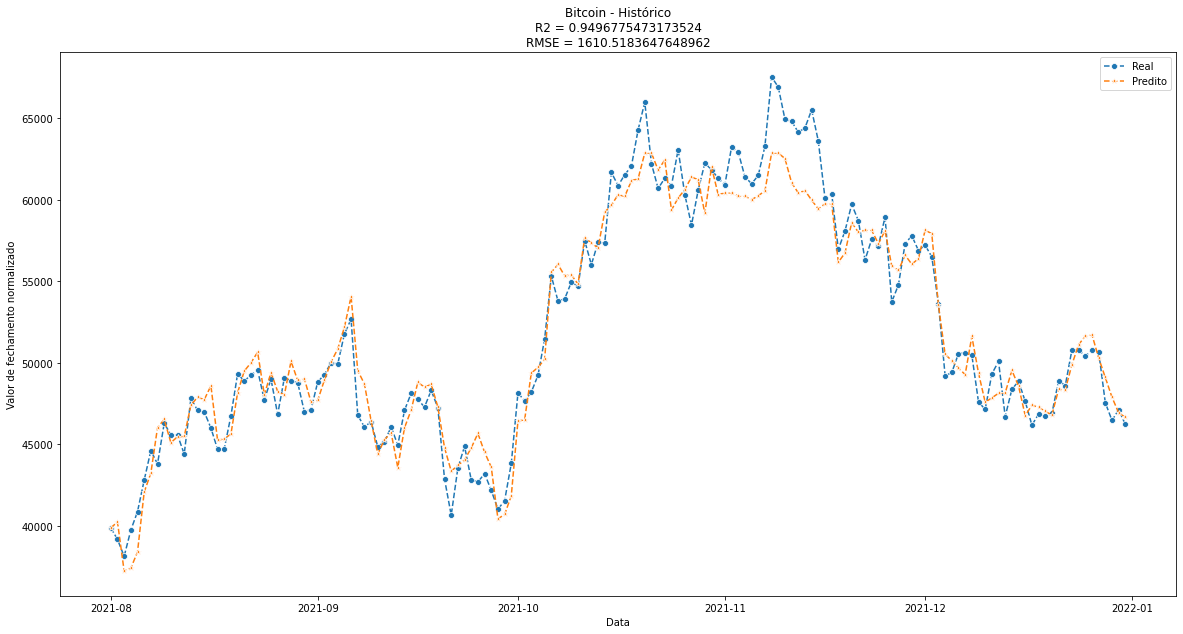

In [43]:
rmse_xgb_opt, r2_xgb_opt, y_test_xgb_opt, y_pred_xgb_opt = run_model(df_test_sel, best_model_xgb, X_train_sel, X_test_sel, y_train_sel, y_test_sel)

## Resultados e seleção do melhor modelo
Agora será feita a comparação entre os modelos testados e será escolhido aquele que obteve a melhor performance.

In [44]:
models_data = {'R2 score': [r2_rf, r2_gradboost, r2_xgb, r2_rf_opt, r2_gradboost_opt,r2_xgb_opt], 
               'RMSE': [rmse_rf, rmse_gradboost, rmse_xgb, rmse_rf_opt, rmse_gradboost_opt, rmse_xgb_opt],
               'Modelo': ['Random Forest', 'Gradient Boost', 'XGBoost', 'Random Forest', 'Gradient Boost', 'XGBoost'],
               'Versão': ['Baseline', 'Baseline', 'Baseline', 'Otimizado', 'Otimizado', 'Otimizado']}

models_df = pd.DataFrame(data = models_data).set_index(['Versão', 'Modelo'])

models_df

R2 score         RMSE
Versão    Modelo                               
Baseline  Random Forest   0.747346  3608.675707
          Gradient Boost  0.940417  1752.456717
          XGBoost         0.834390  2921.649168
Otimizado Random Forest   0.805613  3165.326989
          Gradient Boost  0.942813  1716.849825
          XGBoost         0.949678  1610.518365

### Análise
Observando os resultados obtidos, fica claro que houve uma melhora de todos os modelos após a otimização de hiperparâmetros e seleção de características.

O modelo que obteve a melhor performance foi o XGBoost, com um score R2 de aproximadamente 94,97% e RMSE de 1610,51. Quando comparado com sua versão Baseline, a versão otimizada obteve uma melhora no score R2 de aproximadamente 11,53% e no RMSE de aproximadamente 1.333,13. Ambas representam melhoras significativas.

## Análise dos resultados
Nessa seção serão analisados os resultados obtidos pelo melhor modelo.

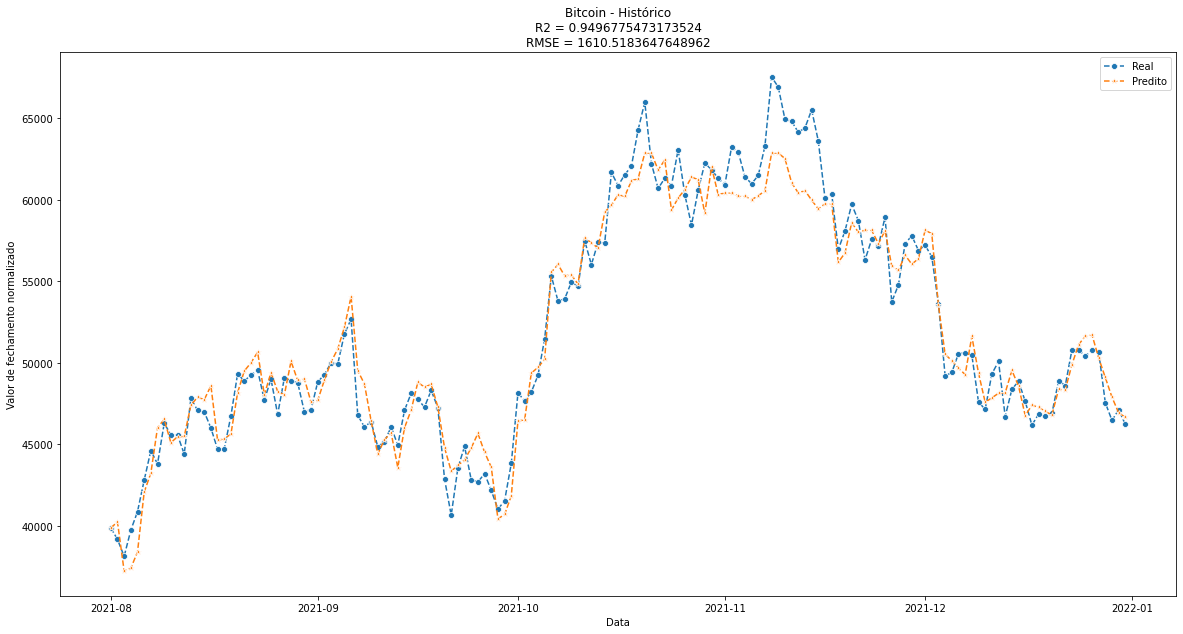

In [45]:
# Gerando o gráfico comparando os valores reais com os preditos
rmse_xgb_opt, r2_xgb_opt, y_test_xgb_opt, y_pred_xgb_opt = run_model(df_test_sel, best_model_xgb, X_train_sel, X_test_sel, y_train_sel, y_test_sel)

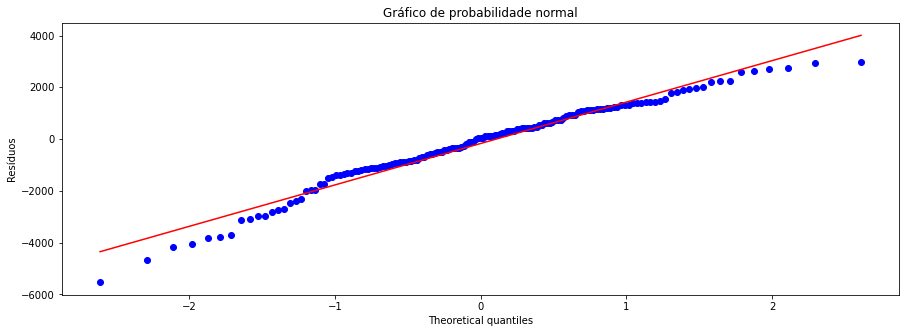

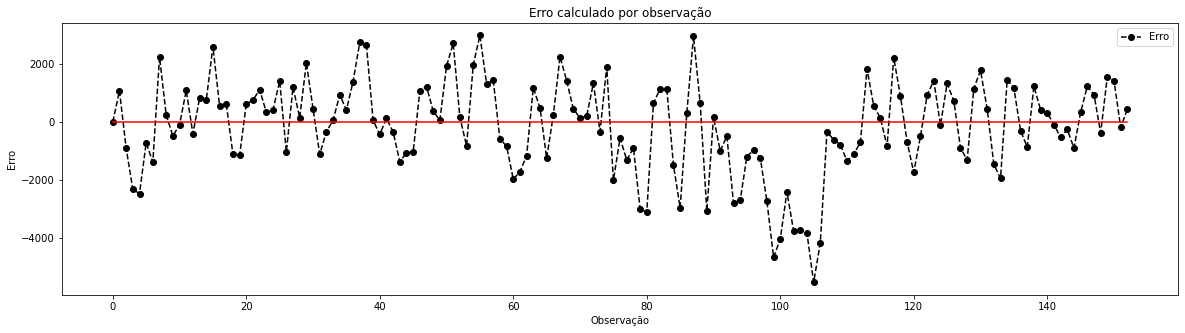

In [46]:
# Gráfico de distribuição dos erros
plt.figure(figsize = (20,3))
p1 = stats.probplot((y_pred_xgb_opt - y_test_sel), plot=plt)
plt.title('Gráfico de probabilidade normal')
plt.ylabel('Resíduos');
plt.show()

# Gráfico que mostra o erro entre o valor real e o calculado a cada observação
plt.figure(figsize=(20,3))
plt.plot((y_pred_xgb_opt-y_test_sel.values), c='k', marker = 'o', markersize=6, linestyle='--', label='Erro')
plt.plot(np.zeros(len(y_test_sel.values)), c='r')
plt.xlabel('Observação')
plt.ylabel('Erro')
plt.title('Erro calculado por observação')
plt.legend();

Para o primeiro gráfico, observa-se que a distribuição dos erros está mais concentrada no meio da curva, o que sigifica que não houve uma dispersão muito elevada nos erros encontrados, com alguns extremos localizados nas pontas da curva.

O segundo gráfico mostra os erros calculados por observação. Nele é possível observar que de fato a maioria dos erros se localiza na faixa de valores entre aproximadamente -2200 e 1700. É possível observar que houveram alguns extremos, onde o modelo não soube captar as variações no preço do bitcoin de forma ideal.

## Análise SHAP
A última análise a ser realizada é a análise do SHAP. Nela serão identificadas as principais características que impactaram na interpretação do modelo dos dados utilizados e como cada característica impactou o resultado obtido.

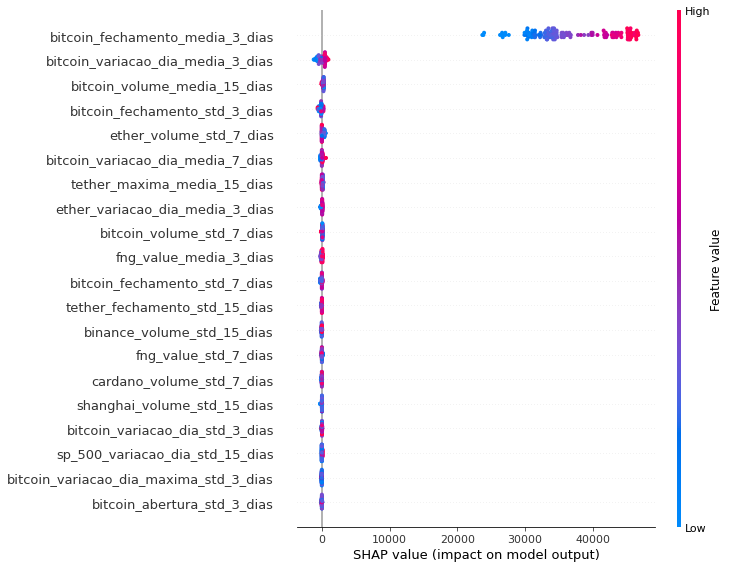

In [47]:
# Executando o algoritmo SHAP no melhor modelo
explainer = shap.TreeExplainer(best_model_xgb)
shap_values = explainer.shap_values(X_test_sel)
shap.summary_plot(shap_values, X_test_sel)

### Análise
É possível observar que a principal característica utilizada pelo modelo é a média do preço de fechamento do bitcoin nos últimos 3 dias. A variação média, desvio padrão do preço de fechamento e volume do bitcoin nos últimos 3 e 15 dias também são relevantes, o que de certa forma é esperado. Pode-se observar também que o modelo enxerga uma relação em valores calculados a partir de outras criptomoedas e no índice de medo.

# Conclusão

Nesse projeto, foi possível a obtenção de um modelo cuja performance alcançada foi considerada bastante satisfatória, onde o modelo XGBoost desenvolvido conseguiu obter um score R2 de aproximadamente 94,97% e um valor de RMSE de 1610,52 a partir dos dados históricos de feveveiro de 2018 até dezembro de 2021.

Foram realizadas diversas etapas de um projeto típico de Ciência de Dados, desde a aquisição e tratamento dos dados iniciais, criação de características a partir das características iniciais (Engenharia de Variáveis), criação de um modelo de referência (baseline), seleção de características através de diferentes algoritmos (no caso desse projeto foram utilizados algoritmos baseados em filtro), otimização dos hiperparâmetros dos modelos e, por fim, a seleção do melhor modelo utilizando métricas de avaliação de performance adequadas.

Para projetos futuros, considero que variáveis obtidas a partir de análise de redes sociais como sendo possíveis características importantes, visto que esse esse tipo de ativo financeiro (criptomoedas), por ainda ser algo bastante recente e novo no mercado, ainda possui um grande fator especulativo cujo valor sofre grande influência de ações/declarações feitos por grandes players (pessoas e empresas).

Como principal ponto de melhoria do modelo, destacaria a melhora da capacidade do modelo acompanhar variações repentinas nos valores. É possível observar que as observações que obtiveram o maior erro foram aquelas onde o preço variou a direção de subida/descida bruscamente.
